## 기본설정 및 전처리

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
#from keplergl import KeplerGl

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

In [2]:
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])

In [3]:
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

In [4]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

#### 청주시_도시재생계획구역

In [5]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/27.청주시_도시재생계획구역.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
crp_df = pd.json_normalize(geojson_data) # city_revitalize_planning_map_df
crp_df['geometry'] = crp_df['geometry.coordinates'].apply(lambda x : make_pol(x))

# 폴리곤의 중점을 찾아 확장된 폴리곤 생성(1도의 위도 변화는 대략 111.32 킬로미터)
polygon_expanded = crp_df['geometry'].iloc[0].centroid.buffer(0.015)
crp_df['centroid_polygon_geometry'] = [polygon_expanded]

#### 원도심 구역 시각화

In [6]:
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13)

# crp_df의 각 다각형을 지도에 추가
for index, row in crp_df.iterrows():
    style_function = lambda x: {'fillColor': 'navy', 'color': 'navy', 'weight': 2}
    polygon = folium.GeoJson(row['geometry'], style_function=style_function)  
    polygon.add_to(m)

# 지도를 표시
m

#### 원도심 centroid 반경 1.5km구역

In [7]:
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13)

# crp_df의 각 다각형을 지도에 추가
for index, row in crp_df.iterrows():
    style_function = lambda x: {'fillColor': 'navy', 'color': 'navy', 'weight': 2}
    polygon = folium.GeoJson(row['centroid_polygon_geometry'], style_function=style_function)  
    polygon.add_to(m)

# 지도를 표시
m

#### 격자(매핑용)

In [8]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/26.청주시_격자(매핑용).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
# crp_df에서 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
polygon_expanded = crp_df['centroid_polygon_geometry'].iloc[0]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
# grid_map_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid = grid_map_df[grid_map_df['geometry'].intersects(polygon)].reset_index(drop=True) # polygon과 교차하거나 포함하는 경우를 모두 선택, within 은 포함
# grid_map_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid_expanded = grid_map_df[grid_map_df['geometry'].intersects(polygon_expanded)].reset_index(drop=True) # polygon과 교차하거나 포함하는 경우를 모두 선택

In [9]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=14)

# 필터링된 원도심 grid(격자) 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
grid_geojson = filtered_grid['geometry'].to_json()
grid_layer = folium.GeoJson(
    grid_geojson,
    name="격자",
    style_function=lambda feature: {
        'fillColor': 'navy',
        'color': 'black',
        'weight': 1
    }
)
grid_layer.add_to(m)
# 맵 출력
m

#### 청주시 상세 도로망 & 도로명주소 데이터 필터링 및 통합

In [10]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/13.청주시_상세도로망.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : LineString(x))
roadsystem_df['properties.link_id'] = roadsystem_df['properties.link_id'].astype(str)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadsystem = roadsystem_df[roadsystem_df['geometry'].intersects(polygon)].reset_index(drop=True)

# GeoJSON 파일 불러오기
with open('SBJ_2309_001/16.청주시_도로명주소(도로).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_road_df = pd.json_normalize(geojson_data['features'])
roadname_road_df['geometry'] = roadname_road_df['geometry.coordinates'].apply(lambda x: LineString(x))
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadname_road_df = gpd.GeoDataFrame(roadname_road_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadname_road = roadname_road_df[roadname_road_df['geometry'].within(polygon)].reset_index(drop=True)

# 통합 도로망 df
tot_roadsystem = pd.concat([filtered_roadsystem[['geometry']], filtered_roadname_road[['geometry']]])

#### 청주시 시장현황 필터링

In [11]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
market_df = pd.read_csv('SBJ_2309_001/6.청주시_시장현황.csv')
market_df = geo_transform(market_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# market_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_market = market_df[market_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 주차장 현황

In [79]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
parking_df = pd.read_csv('SBJ_2309_001/7.청주시_주차장현황.csv')
parking_df = geo_transform(parking_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0].centroid.buffer(0.01)
# parking_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_parking = parking_df[parking_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [80]:
filtered_points_parking

carpark_nm carpark_type                         addr  slots  \
0            상공회의소           노상         충청북도 청주시 상당구 상당로 102     25   
1             명문식당           노상           충청북도 청주시 상당구 우암산로4     30   
2            고려삼계탕           노상     충청북도 청주시 상당구 교동로3번길 48-1     29   
3            메리츠화재           노상      충청북도 청주시 상당구 교동로3번길 127     20   
4   교서로(지하상가~주성초교)           노상          충청북도 청주시 상당구 교서로 45     49   
5           제일학원 앞           노상      충청북도 청주시 상당구 교동로3번길 153     26   
6             시청후문           노상     충청북도 청주시 상당구 상당로143번길 16     26   
7             청주병원           노상          충청북도 청주시 상당구 중앙로 83     35   
8           한전아파트앞           노상   충청북도 청주시 상당구 사직대로361번길 113     28   
9            청중후문앞           노상   충청북도 청주시 상당구 사직대로361번길 125     46   
10          현대자동차앞           노상         충청북도 청주시 상당구 교서로 4-1     25   
11             공고앞           노상          충청북도 청주시 상당구 교서로 17     18   
12         상호저축은행앞           노상    충청북도 청주시 상당구 사직대로350번길 53     18   
13           우리은행앞           노상          충청북도 청주시 상당구 성안로 52     14   
14          청주문화원앞           노상     충청북도 청주시 상당구 남문로2가 120-1     10   
15           제일조명앞           노상       충청북도 청주시 상당구 남사로94번길 2     16   
16      구 남궁병원~남사교           노상        충청북도 청주시 상당구 남사로 70-3     23   
17       대성동주민센터 옆           노상           충청북도 청주시 상당구 당산로 7      7   
18         우성아파트부근           노상          충청북도 청주시 상당구 당산로 21     17   
19         무심동로제내지           노상  충청북도 청주시 상당구 무심동로372번길 2-15     61   
20               -           노상        충청북도 청주시 서원구 무심서로 565     50   
21            무심천쪽           노상        충청북도 청주시 서원구 무심서로 565     30   
22           용화사근처           노상        충청북도 청주시 서원구 무심서로 565     20   
23    서문교밑(사직동114)           노상      충청북도 청주시 서원구 사직대로 308-2    247   
24      서문교 남사교 사이           노상         충청북도 청주시 서원구 사직동 114     60   
25           사직분수대           노상       충청북도 청주시 서원구 사직동 710-2     40   
26           공영주차장           노외         충청북도 청주시 상당구 영동 10-3     10   
27           공영주차장           노외         충청북도 청주시 상당구 영동 13-3      6   
28          공한지주차장           노외        충청북도 청주시 상당구 영동 41-25      3   
29           일진주차장           노외      충청북도 청주시 상당구 북문로3가 65-5     72   
30            수암골5           노외       충청북도 청주시 상당구 수동 112-21     12   
31            수암골4           노외        충청북도 청주시 상당구 수동 115-7     11   
32         삼일공원주차장           노외        충청북도 청주시 상당구 수동 159-1     32   
33          공한지주차장           노외         충청북도 청주시 상당구 서운동 1-1     18   
34       육거리 제2주차장           노외      충청북도 청주시 상당구 석교동 125-88     89   
35       육거리 제1주차장           노외        충청북도 청주시 상당구 석교동 60-4     32   
36       대성동 155-1           노외         충청북도 청주시 상당구 대성동 150     10   
37       대성동 공영주차장           노외       충청북도 청주시 상당구 대성동 122-5     24   
38          공한지주차장           노외       충청북도 청주시 상당구 대성동 121-2     12   
39          공한지주차장           노외      충청북도 청주시 서원구 사직동 223-13      5   

           lon        lat                    geometry  
0   127.490487  36.637486  POINT (127.49049 36.63749)  
1   127.490514  36.639075  POINT (127.49051 36.63908)  
2   127.490837  36.639529  POINT (127.49084 36.63953)  
3   127.490239  36.643059  POINT (127.49024 36.64306)  
4   127.485254  36.641427  POINT (127.48525 36.64143)  
5   127.490198  36.644232  POINT (127.49020 36.64423)  
6   127.487858  36.641205  POINT (127.48786 36.64121)  
7   127.487734  36.644668  POINT (127.48773 36.64467)  
8   127.486806  36.641929  POINT (127.48681 36.64193)  
9   127.485956  36.642952  POINT (127.48596 36.64295)  
10  127.486655  36.637249  POINT (127.48665 36.63725)  
11  127.485680  36.637646  POINT (127.48568 36.63765)  
12  127.486485  36.634165  POINT (127.48648 36.63417)  
13  127.489104  36.632230  POINT (127.48910 36.63223)  
14  127.489250  36.632494  POINT (127.48925 36.63249)  
15  127.485307  36.631754  POINT (127.48531 36.63175)  
16  127.482873  36.631530  POINT (127.48287 36.63153)  
17  127.496744  36.632919  POINT (127.49674 36.63292)  
18  127.497766  36.633845  POINT

In [91]:
def find_nearest_parking(point, parking_df):
    """
    특정 지점에서 가장 가까운 주차장 열 개를 필터링하는 함수

    Parameters:
    - point: shapely.geometry.Point 객체로 특정 지점의 좌표를 나타냄
    - parking_df: 주차장 정보를 담고 있는 GeoDataFrame

    Returns:
    - filtered_df: 특정 지점에서 가장 가까운 주차장 열 개를 포함하는 GeoDataFrame
    """
    # 주차장 데이터프레임의 'geometry' 열이 Point 객체임을 확인
    assert isinstance(point, Point), "Input 'point' should be a shapely.geometry.Point object."
    assert 'geometry' in parking_df.columns, "Input 'parking_df' should have a 'geometry' column."

    # 주차장 데이터프레임 복사
    filtered_df = parking_df.copy()

    # 특정 지점에서 가장 가까운 순으로 정렬
    filtered_df['distance'] = parking_df['geometry'].distance(point)
    filtered_df = filtered_df.sort_values(by='distance').head(10)

    return filtered_df[['carpark_nm', 'addr', 'slots', 'geometry']]

In [95]:
# 예시: 청주 중앙시장의 좌표
specific_point = Point(127.489191643112,36.6393846590262)

# 함수 호출
result_df = find_nearest_parking(specific_point, filtered_points_parking)

# 결과 출력
result_df

C:\Users\HJK\AppData\Local\Temp\ipykernel_34820\31691725.py:20: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




carpark_nm                        addr  slots  \
1             명문식당          충청북도 청주시 상당구 우암산로4     30   
2            고려삼계탕    충청북도 청주시 상당구 교동로3번길 48-1     29   
6             시청후문    충청북도 청주시 상당구 상당로143번길 16     26   
0            상공회의소        충청북도 청주시 상당구 상당로 102     25   
29           일진주차장     충청북도 청주시 상당구 북문로3가 65-5     72   
10          현대자동차앞        충청북도 청주시 상당구 교서로 4-1     25   
8           한전아파트앞  충청북도 청주시 상당구 사직대로361번길 113     28   
3            메리츠화재     충청북도 청주시 상당구 교동로3번길 127     20   
11             공고앞         충청북도 청주시 상당구 교서로 17     18   
4   교서로(지하상가~주성초교)         충청북도 청주시 상당구 교서로 45     49   

                      geometry  
1   POINT (127.49051 36.63908)  
2   POINT (127.49084 36.63953)  
6   POINT (127.48786 36.64121)  
0   POINT (127.49049 36.63749)  
29  POINT (127.48770 36.64126)  
10  POINT (127.48665 36.63725)  
8   POINT (127.48681 36.64193)  
3   POINT (127.49024 36.64306)  
11  POINT (127.48568 36.63765)  
4   POINT (127.48525 36.64143)

C:\Users\HJK\AppData\Local\Temp\ipykernel_34820\31691725.py:20: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.





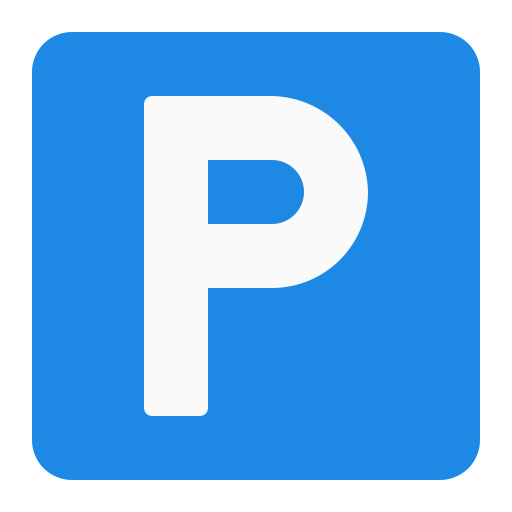
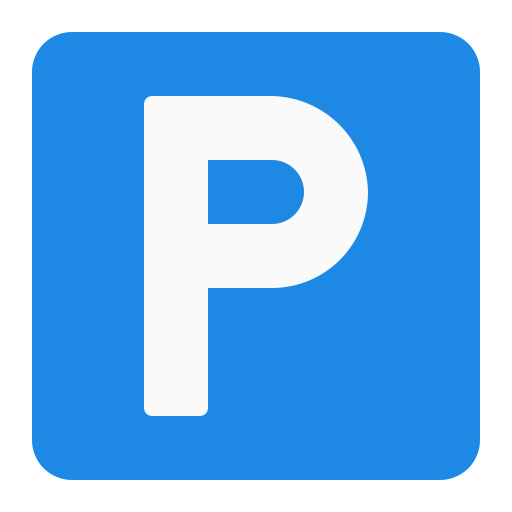
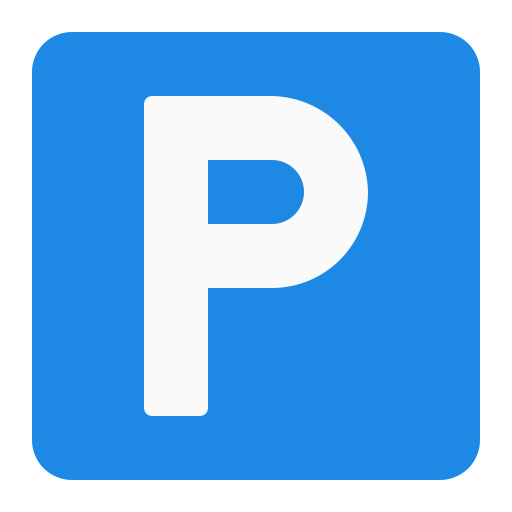
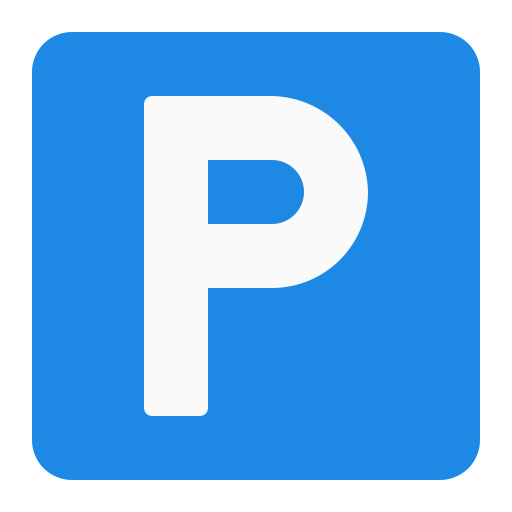
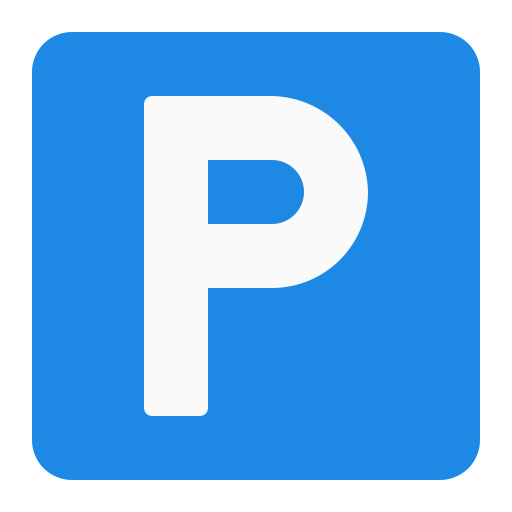
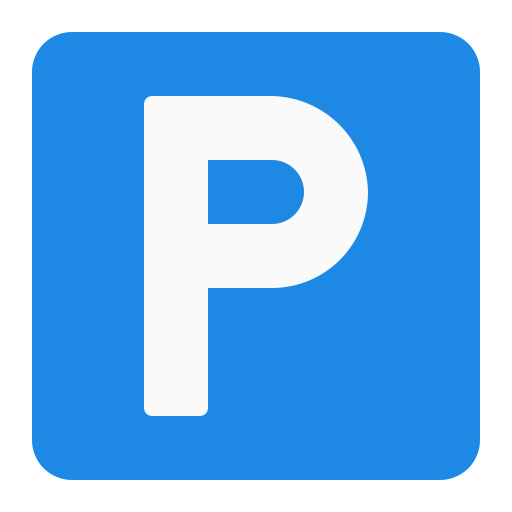
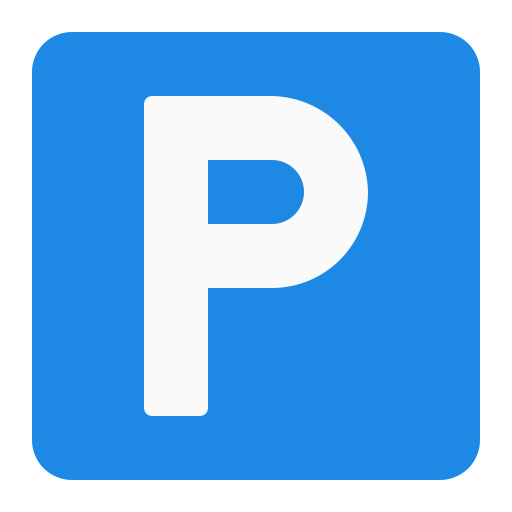
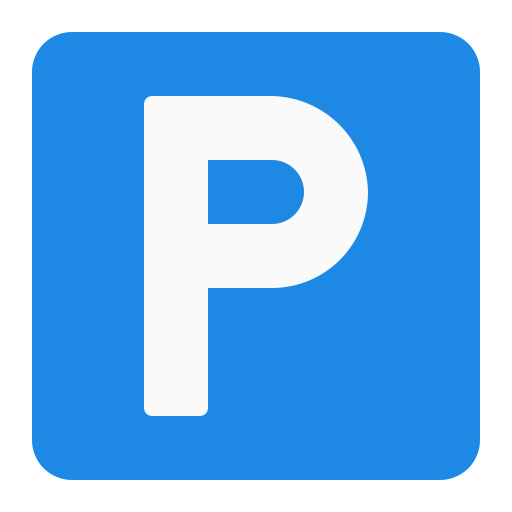
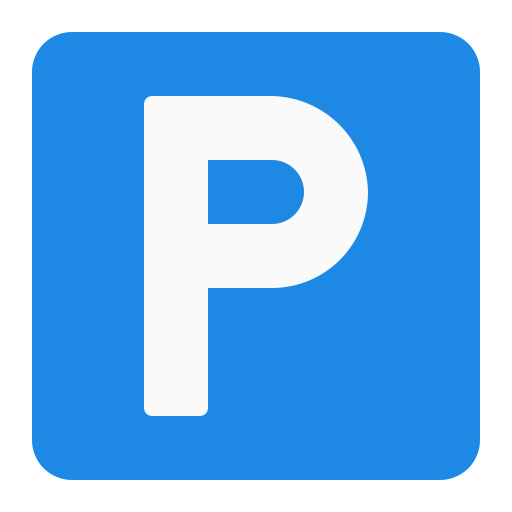
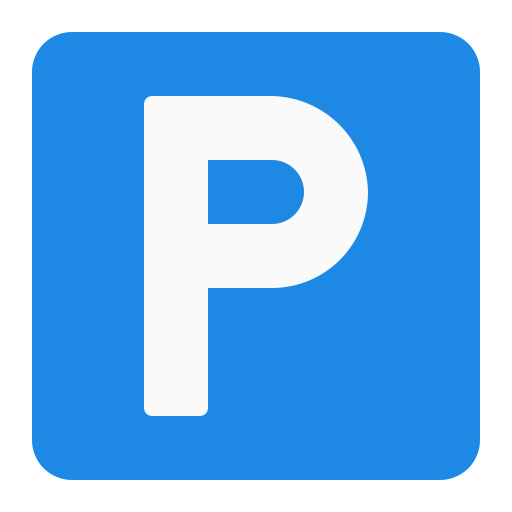

In [94]:
def visualize_parking_on_folium(specific_point, parking_df):
    """
    folium을 사용하여 특정 지점과 주차장을 시각화하고 선으로 연결하는 함수

    Parameters:
    - specific_point: shapely.geometry.Point 객체로 특정 지점의 좌표를 나타냄
    - parking_df: 주차장 정보를 담고 있는 GeoDataFrame

    Returns:
    - folium_map: 특정 지점과 주차장을 시각화한 folium Map 객체
    """
    # folium 지도 생성
    folium_map = folium.Map(location=[specific_point.y, specific_point.x], zoom_start=15)

    # 특정 지점을 지도에 추가
    folium.Marker([specific_point.y, specific_point.x], popup='특정 지점', icon=folium.Icon(color='red')).add_to(folium_map)

    # 필터링된 주차장을 지도에 추가
    for idx, row in parking_df.iterrows():
        # 주차 가능 대수에 따라 아이콘 크기 조정
        icon_size = int(row['slots']) * 5 * 0.1  # 주차 가능 대수에 따라 조절

        popup_text = f"{row['carpark_nm']} - {row['slots']}대"
        folium.Marker(location=([row['geometry'].y, row['geometry'].x]),
        icon = folium.CustomIcon(icon_image='icon/주차장.png', icon_size=(icon_size, icon_size))).add_to(folium_map).add_child(folium.Popup(popup_text, max_width=200))

        # 선 추가
        line = folium.PolyLine([(specific_point.y, specific_point.x), (row['geometry'].y, row['geometry'].x)],
                               color='blue', weight=2.5, opacity=1).add_to(folium_map)

    return folium_map

# 예시: 중앙시장의 좌표
specific_point = Point(127.489191643112,36.6393846590262)

# 함수 호출
result_df = find_nearest_parking(specific_point, filtered_points_parking)

# folium으로 시각화
folium_map = visualize_parking_on_folium(specific_point, result_df)

# folium 지도 출력
folium_map


#### 청주시 공공기관 및 주요지점 현황

In [13]:
public_df = pd.read_csv('SBJ_2309_001/25.청주시_공공기관_및_주요지점현황.csv')
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
public_df = geo_transform(public_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# public_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_public = public_df[public_df['geometry'].within(polygon)]
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('공공기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('시군청', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('도단위기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('민간기관', '상업시설')
filtered_points_public = filtered_points_public.drop_duplicates(subset='geometry', keep='first').reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

#### 청주시 공원 현황

In [14]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
park_df = pd.read_csv('SBJ_2309_001/8.청주시_공원현황.csv')
park_df = geo_transform(park_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# park_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_park = park_df[park_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 인도(보도) 시각화

In [15]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/17.청주시_인도(보도).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
sidewalk_df = pd.json_normalize(geojson_data['features'])
sidewalk_df['geometry'] = sidewalk_df['geometry.coordinates'].apply(make_lin)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
sidewalk_df = gpd.GeoDataFrame(sidewalk_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_sidewalk = sidewalk_df[sidewalk_df['geometry'].intersects(polygon)].reset_index(drop=True)

#### 청주시 폐공장현황

In [16]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
factory_df = pd.read_csv('SBJ_2309_001/9.청주시_폐공장현황.csv')
factory_df = geo_transform(factory_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_factory = factory_df[factory_df['geometry'].within(polygon)]

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 문화재 현황

In [17]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
culture_assets_df = pd.read_csv('SBJ_2309_001/5.청주시_유적지_문화재현황.csv')
culture_assets_df = geo_transform(culture_assets_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_culture = culture_assets_df[culture_assets_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 학교 현황

In [18]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임 변환
school_df = pd.read_csv('SBJ_2309_001/24.청주시_학교현황.csv')
school_df = geo_transform(school_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_school = school_df[school_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 어린이집 유치원 현황

In [19]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
kinder_df = pd.read_csv('SBJ_2309_001/28.청주시_어린이집_유치원현황.csv')
kinder_df = geo_transform(kinder_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_kinder = kinder_df[kinder_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 상권정보

In [20]:
# 상권정보 데이터 로드 및 GeoDataFrame으로 변환
trading_area_df = pd.read_csv('SBJ_2309_001/18.청주시_상권정보.csv')
trading_area_df = geo_transform(trading_area_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_trading_area = trading_area_df[trading_area_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 가로수 현황 (공공데이터포털 - 산림청_도시숲가로수관리 가로수 현황 https://www.data.go.kr/data/15120900/fileData.do)

In [21]:
'''산림청_도시숲가로수관리 가로수 현황_20221231 데이터 정제 완료 -'''
# street_tree_df = pd.read_csv('SBJ_2309_001/산림청_도시숲가로수관리 가로수 현황_20221231.csv', encoding='cp949')
# street_tree_df = street_tree_df[['시군구명', '도로구간명', '수종명', '지역X좌표', '지역Y좌표']]
# street_tree_df = street_tree_df[street_tree_df['시군구명'].str.contains('청주')].reset_index(drop=True)

# # EPSG 5186에서 EPSG 4326으로 좌표 변환을 수행하는 함수 생성
# def transform_coordinates(row):
#     in_proj = pyproj.Proj(init='epsg:5186')
#     out_proj = pyproj.Proj(init='epsg:4326')
#     lon, lat = pyproj.transform(in_proj, out_proj, row['지역X좌표'], row['지역Y좌표'])
#     return pd.Series({'lat': lat, 'lon': lon})

# # '지역X좌표'와 '지역Y좌표'를 EPSG 4326으로 변환하고 'lat' 및 'lon' 열로 이름 변경
# street_tree_df[['lat', 'lon']] = street_tree_df.apply(transform_coordinates, axis=1)
# # '지역X좌표'와 '지역Y좌표' 열을 삭제 (선택 사항)
# street_tree_df.drop(['지역X좌표', '지역Y좌표'], axis=1, inplace=True)

# 가로수 데이터프레임 로드 및 GeoPandas 변환
street_tree_df = pd.read_csv('SBJ_2309_001/29.청주시_가로수현황.csv', encoding='UTF8')
street_tree_df = geo_transform(street_tree_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_tree = street_tree_df[street_tree_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt

# shapefile 경로 설정
shapefile_path = 'SBJ_2309_001/SG05_36706050_20230126/36706050.shp'

# shapefile을 GeoDataFrame으로 읽기
gdf = gpd.read_file(shapefile_path)
gdf.set_crs(epsg=4326, allow_override=True)
gdf_1 = gdf.to_crs(epsg=4326)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_gdf_1 = gdf_1[gdf_1['geometry'].within(polygon)].reset_index(drop=True)

In [68]:
meta = pd.read_csv("SBJ_2309_001/SG05_36706050_20230126/meta.csv")

# RGB 색상코드 변환 함수 정의
def convert_to_rgb(row):
    rgb_values = row['RGB색상코드값'].split('-')
    rgb_string = f'rgb({rgb_values[0]}, {rgb_values[1]}, {rgb_values[2]})'
    return rgb_string

# 변환 함수를 적용하여 새로운 열 생성
meta['RGB색상코드'] = meta.apply(convert_to_rgb, axis=1)
color_dic = dict(zip(meta['세분류코드'], meta['RGB색상코드']))

In [76]:
filtered_gdf_1['L3_NAME'].unique()

array(['단독주거시설', '공동주거시설', '상업ㆍ업무시설', '문화·체육·휴양시설', '도로', '교육ㆍ행정시설',
       '기타 공공시설', '경지정리가 안 된 밭', '기타초지', '운동장', '기타 나지'], dtype=object)

In [78]:
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13)

# 기본 배경지도를 항상 표시하도록 설정 및 통합도로망 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
# crp_df의 각 다각형을 지도에 추가
for index, row in crp_df.iterrows():
    style_function = lambda x: {'fillColor': 'none', 'color': 'navy', 'weight': 2}
    polygon = folium.GeoJson(row['geometry'], name="원도심", style_function=style_function)  
    polygon.add_to(m)


# crp_df의 각 다각형을 지도에 추가
for index, row in filtered_gdf_1.iterrows():
    if row['L3_NAME'] in ['경지정리가 안 된 밭', '기타초지', '기타 나지']:
        color = color_dic[int(row['L3_CODE'])]
        popup_text = f"{row['L3_NAME']}"
        folium.GeoJson(
            row['geometry'].__geo_interface__,
            style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 2},
            name='유휴부지'
        ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))
    else:
        pass

# LayerControl을 사용하여 연도 선택
folium.LayerControl(collapsed=False).add_to(m)

# 지도를 표시
m

### 네트워트 x 도로망 분석, 회사컴에서 안됨.

https://thlee33.medium.com/tsp%EB%A5%BC-%EC%A0%81%EC%9A%A9%ED%95%9C-%EB%9A%9C%EB%B2%85%EC%9D%B4-%EC%97%AC%ED%96%89-%EC%BD%94%EC%8A%A4-%EC%84%A4%EA%B3%84-6a8723e6b145

https://whiplash-bd.tistory.com/57

https://thlee33.medium.com/osmnx%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EB%8F%84%EB%A1%9C-%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC-%EB%B6%84%EC%84%9D-59b543eb7836

https://anweh.tistory.com/36

In [7]:
import networkx as nx
import osmnx as ox
import requests

In [ ]:
# get a graph for some city
# www.openstreetmap.org에서 검색 결과가 city-state-country 단위로 나와야 함 

G = ox.graph_from_place('동대문구, 서울, 대한민국', network_type='drive')
fig, ax = ox.plot_graph(G)